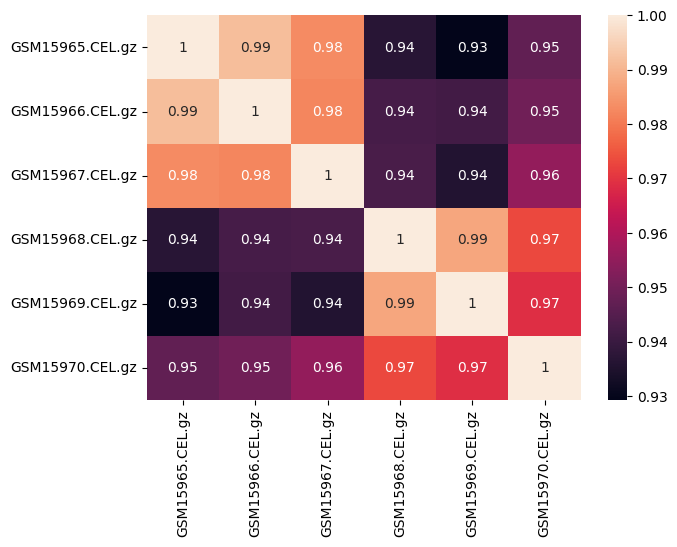

,GSM15965.CEL.gz,GSM15966.CEL.gz,GSM15967.CEL.gz,GSM15968.CEL.gz,GSM15969.CEL.gz,GSM15970.CEL.gz
Gene Symbol,,,,,,
RABGGTA,9.709046,9.626306,9.751121,10.058598,9.790746,10.228651
MAPK3,10.174661,10.038974,10.394435,10.359346,10.035482,10.707925
TIE1,8.660592,8.416663,9.142468,9.295671,8.873215,9.559935
CYP2C19,6.209703,6.127126,6.280036,6.527019,6.689310,6.795956
CXCR5,9.041132,8.917423,8.959817,9.098235,9.402771,9.303698
...,...,...,...,...,...,...
TFRC,6.305673,6.060284,6.205693,6.313565,6.434132,6.295561
TFRC,6.692915,7.015564,6.766895,7.133165,7.296669,6.879348
Fas,6.581938,6.924634,6.487449,6.839402,6.942704,6.780771


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataprocess as dp

matrix = pd.read_csv('matrix_GSE1009', sep='\t')

matrix = matrix.dropna(axis=0, how='any', subset='Gene Symbol') # remove rows that don't contain gene symbols, which are affymetrix controls

matrix = matrix.set_index('Gene Symbol')

affy_ID = matrix.ID.tolist() # save affymetrix gene IDs before removing

matrix = matrix.loc[:,'GSM15965.CEL.gz':'GSM15970.CEL.gz']

#matrix.to_csv('refined_matrix_GSE1009', sep = '\t')

f = plt.figure(figsize=(7,5))
sns.heatmap(data =  matrix.corr(), annot=True) # , cmap='coolwarm', linewidths=0.5
plt.show()

matrix

## DEG read for affymetrix probeset collapse GSE30528

In [2]:
DEG_matrix = pd.read_csv('Diff_analysis_GSE30528', sep='\t') # read DEA results from R

DEG_matrix = DEG_matrix[['logFC','adj.P.Val','Gene Symbol']] # select desired columns

DEG_matrix = DEG_matrix.dropna(subset=['Gene Symbol']) # drop rows that contain no mapped gene symbol

# loop to obtain the total amount of identified genes with no repeat
gene_list = list() 
for gene in DEG_matrix['Gene Symbol'].tolist(): 
    if gene in gene_list:
        continue
    else:
        gene_list.append(gene)

print(len(gene_list))
DEG_matrix

13515


,logFC,adj.P.Val,Gene Symbol
208933_s_at,-2.437564,2.464923e-09,LGALS8
204298_s_at,-2.974076,2.464923e-09,LOX
210105_s_at,-1.300298,1.694170e-07,FYN
212344_at,-2.069991,2.326035e-07,SULF1
204417_at,-1.734539,2.378848e-07,GALC
...,...,...,...
216347_s_at,-0.000091,9.996850e-01,PPP1R13B
208928_at,0.000135,9.998047e-01,POR
221307_at,0.000023,9.999077e-01,KCNIP1
204535_s_at,0.000020,9.999515e-01,REST


In [3]:

def median_collapse(df:pd.DataFrame, # a DEG data frame with 3 columns: **logFC, adj.P.Val and Gene Symbol**
                    glist:list, # list with unique gene sumbols identified by the affymemtrix analysis
                    label:str,# column of the dataframe that will be used to group and filter
                    verbose = False): 
    empty = pd.DataFrame()
    for gene in glist:
        table = df[df[label] == gene]
        #print(test)
        median = table.median(numeric_only=True) # calculate the median value of every variable
        #print(median)
        if median['logFC'] in table['logFC'].tolist(): # in case the probeset contains an even amount of probes...
            table = table.loc[table['logFC']==median['logFC']] # select row that contains the median logFC value
            table['Probeset Type'] = 'odd' # add a control column
            empty = pd.concat([empty,table],ignore_index=True) # add this row to an external empty df to save it
            if verbose == True:
                print(f'parsing information for gene {gene}, odd probeset')
        else:# in case the probeset contains an odd amount of probes...
            dic = dict()
            dic['logFC'] = float(median['logFC']) # add the median logFC value to save it
            p_vals = dict()
            for p_val in table['adj.P.Val'].tolist(): 
                diff = p_val - median['adj.P.Val'] # calculate the difference between each p_val and the median calculated one
                p_vals[str(p_val)] = diff # add to ann empty dict the difference as a value and the original p_val as a key (in string)
            diff_list = list()
            for key, value in p_vals.items(): 
                if value > 0:
                    diff_list.append(key) # if the calculate difference is bigger than zero, add the respective key (the original p_val) to a separate list
            for keys in diff_list:
                p_vals.pop(keys) # remove p_vals that greater than the mean
            max_diff = max(list(p_vals.values())) # find the closest p_val to the mean from the resultant ones
            #print(list(p_vals.values()))
            for key, value in p_vals.items():
                if value == max_diff:
                    p_val = key # fetch the desired orginal p_val that is closest to the median one
            dic['adj.P.Val'] = round(float(p_val),15) # add the desired p_val to the previous dict
            dic['Gene Symbol'] = gene # add the Gene Symbol column with the respective gene
            table = pd.DataFrame(dic, index = [0]) # transform dict into a df 
            table['Probeset Type'] = 'even' # add a control column
            empty = pd.concat([empty,table],ignore_index=True) # add this row to an external empty df to save it 
            if verbose == True:
                print(f'parsing information for gene {gene}, even probeset') 
            #print(p_val)
    return empty

In [6]:
DEG_filtered = median_collapse(df = DEG_matrix,
                               glist = gene_list,
                               label = 'Gene Symbol'
                               )

parsing information for gene LGALS8, even probeset
parsing information for gene LOX, odd probeset
parsing information for gene FYN, odd probeset
parsing information for gene SULF1, odd probeset
parsing information for gene GALC, even probeset
parsing information for gene TRAM2, even probeset
parsing information for gene ZNF415, odd probeset
parsing information for gene PARVA, odd probeset
parsing information for gene ARHGEF10, even probeset
parsing information for gene USP46, odd probeset
parsing information for gene CA10, odd probeset
parsing information for gene ARHGAP19, even probeset
parsing information for gene CERS6, even probeset
parsing information for gene DPYSL3, even probeset
parsing information for gene MPP5, odd probeset
parsing information for gene TCF7L1, odd probeset
parsing information for gene NPHS1, odd probeset
parsing information for gene ZNF185, odd probeset
parsing information for gene C1orf21, odd probeset
parsing information for gene BTG3, odd probeset
parsing 

In [5]:
DEG_filtered#[DEG_filtered['Gene Symbol']=='SLC25A4']#.loc[(abs(DEG_filtered['logFC'])>= 1) & (DEG_filtered['adj.P.Val'] < 0.05)]

,logFC,adj.P.Val,Gene Symbol,Probeset Type
0,-1.608037,1.875275e-05,LGALS8,even
1,-2.974076,2.464923e-09,LOX,odd
2,-1.689399,4.875768e-04,FYN,odd
3,-2.069991,2.326035e-07,SULF1,odd
4,-0.864347,2.378848e-07,GALC,even
...,...,...,...,...
13510,0.000197,9.995511e-01,SNX5,odd
13511,-0.000091,9.996850e-01,PPP1R13B,odd
13512,0.000135,9.998047e-01,POR,odd
13513,0.000023,9.999077e-01,KCNIP1,odd


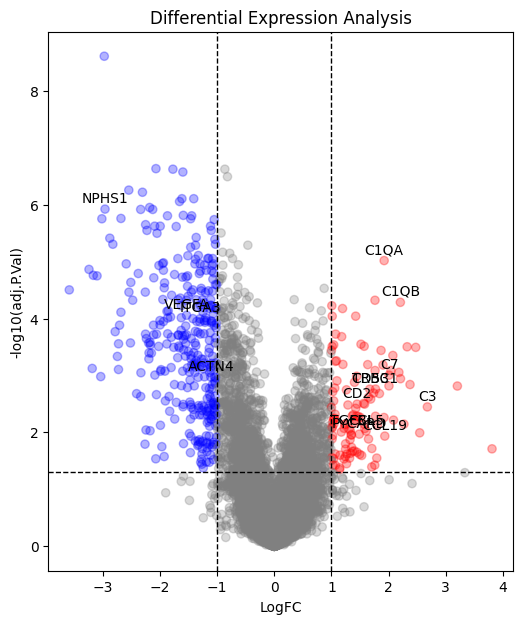

In [173]:
mylist = DEG_filtered.loc[(DEG_filtered['adj.P.Val'] < 0.05) & (abs(DEG_filtered['logFC']) > 1)]['Gene Symbol']
mylist = mylist.loc[mylist.isin(['C7','C1QA','C1QB','C3','TGFBI','PYCARD','CXCL5','CCL19','CCL5','NPHS1','ACTN4','ITGA3','VEGFA','CD53','CD2','TRBC1'])]

import numpy as np

DEG_filtered['-log10(adj.P)'] = -np.log10(DEG_filtered['adj.P.Val'])

plt.figure(figsize=(6, 7))
plt.scatter(DEG_filtered['logFC'], DEG_filtered['-log10(adj.P)'], c=np.where((DEG_filtered['logFC'] > 1) & (DEG_filtered['adj.P.Val'] < 0.05), 'red',
                np.where((DEG_filtered['logFC'] < -1) & (DEG_filtered['adj.P.Val'] < 0.05), 'blue', 'grey')),alpha=0.3)

for i, gene in zip(mylist.index.tolist(),mylist.tolist()):
    plt.annotate(gene, (DEG_filtered['logFC'][i], DEG_filtered['-log10(adj.P)'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.axvline(x=-1, color='black', linestyle='--', linewidth=1)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
plt.axhline(y=1.301, color='black', linestyle='--', linewidth=1)
plt.xlabel('LogFC')
plt.ylabel('-log10(adj.P.Val)')
plt.title('Differential Expression Analysis')
plt.show()

,GSM756992_KS1-HG_U133A_2-2757.CEL.gz,GSM756993_KS1-HG_U133A_2-2871.CEL.gz,GSM756994_KS1-HG_U133A_2-2901.CEL.gz,GSM756995_KS1-HG_U133A_2-2905.CEL.gz,GSM756996_KS1-HG_U133A_2-5117.CEL.gz,GSM756997_KS1-HG_U133A_2-6372.CEL.gz,GSM756998_KS1-HG_U133A_2-6393.CEL.gz,GSM756999_KS1-HG_U133A_2-6395.CEL.gz,GSM757000_KS1-HG_U133A_2-6574.CEL.gz,GSM757001_KS1-HG_U133A_2-2772.CEL.gz,...,GSM757004_KS1-HG_U133A_2-2913.CEL.gz,GSM757005_KS1-HG_U133A_2-2919.CEL.gz,GSM757006_KS1-HG_U133A_2-2921.CEL.gz,GSM757007_KS1-HG_U133A_2-2923.CEL.gz,GSM757008_KS1-HG_U133A_2-3427.CEL.gz,GSM757009_KS1-HG_U133A_2-3467.CEL.gz,GSM757010_KS1-HG_U133A_2-3470.CEL.gz,GSM757011_KS1-HG_U133A_2-5111.CEL.gz,GSM757012_KS1-HG_U133A_2-5116.CEL.gz,GSM757013_KS1-HG_U133A_2-5118.CEL.gz
218232_at,8.792918,6.849894,7.926777,7.698348,7.908608,6.834258,8.049612,8.162838,7.803267,5.660363,...,5.466074,5.714138,5.851675,5.663832,5.264211,6.461583,6.628779,5.896975,5.424173,5.282244


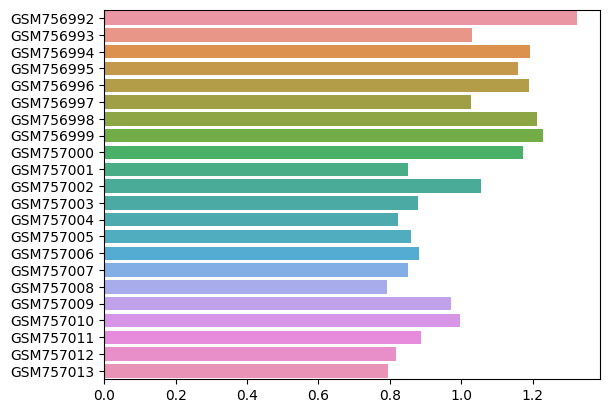

In [125]:
norm_matrix = pd.read_csv('matrix_GSE30528',sep='\t')

feature_data = pd.read_csv('feature.data',sep='\t')


complement = feature_data['ID'][feature_data['Gene Symbol'].isin(['C7','C1QA','C1QB','C3'])].tolist()

compdf = norm_matrix[norm_matrix.index.isin(complement)]

compdf = compdf.loc[compdf.index == complement[-1]]

names = compdf.columns

exp_values = list()
for variable in names:
    value = float(compdf[variable])
    exp_values.append(value)

mean = sum(exp_values)/len(exp_values)

exp_meanvalues = list()
for n in exp_values:
    value = n/mean
    exp_meanvalues.append(value)

name_edited = list()
for name in names:
    edit = name.split('_')
    edit = edit[0]
    name_edited.append(edit)
sns.barplot(x=exp_meanvalues,y=name_edited)
compdf

### Test to perform sum of specific rows defined by a column index

In [ ]:

#fc_data.loc['Gene Symbol' == 'PLCE1']
def sum_equal_genes(df,sum_label:str,label:str,):
    new_df = pd.DataFrame()
    for gene in gene_data:
        table = df[df[label] == gene]
        table = table[sum_label].mean()
        table = pd.DataFrame({
            sum_label:table,
            label:gene
        },
        index = [1])
        new_df = pd.concat([new_df,table],
        ignore_index=True)
    return new_df

new_df = sum_equal_genes(fc_avarage,'logFC','Gene Symbol')

In [ ]:
new_df.loc[abs(new_df['logFC'])>1]

,logFC,Gene Symbol
0,-3.092209,PLCE1
1,-2.803761,SEMA5A
2,-1.092904,NEBL
3,-2.799127,PALLD
4,-2.288321,IQGAP2
...,...,...
4706,-1.270520,DPP4
4721,-1.263842,PCK1
4914,-1.003064,CXCL11
5475,-1.282933,PLTP
